In [17]:
import re
import numpy as np
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import string 
import nltk 
nltk.download('vader_lexicon')
import warnings 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import csv
warnings.filterwarnings("ignore", category=DeprecationWarning )

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nutrot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
dataset = pd.read_csv('../../Sentiment Analysis/mHealth_apple_appf/A54.csv')
dataset.head()

,title,rating,isEdited,date,userName,review,developerResponse
0,I was NOT a runner,5,False,2020-04-11 00:02:32,Treadytread,I hate running. Never understood the healthnut...,NaN
1,Used to be great...,1,False,2020-04-28 18:59:44,alynn333,I was using this running program through the A...,NaN
2,Not as good as it used to be,2,False,2019-09-16 20:46:18,samisgross,I downloaded the app a few years ago and LOVED...,NaN
3,Killing it,5,False,2020-03-12 01:00:43,sydneyc w,Let me preface this by saying I am a person wh...,NaN
4,Used to be great,3,False,2018-03-27 18:55:18,Ultra Cool Kid,I used this app before this update last year a...,NaN


In [19]:
dataset.count()


title                3000
rating               3000
isEdited             3000
date                 3000
userName             3000
review               3000
developerResponse      87
dtype: int64

In [20]:
dataset = dataset.drop(columns=['isEdited', 'title', 'date', 'developerResponse'])

In [21]:
#dataset = dataset.drop(columns=['reviewId','userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt'])


In [22]:
dataset.dropna()

,rating,userName,review
0,5,Treadytread,I hate running. Never understood the healthnut...
1,1,alynn333,I was using this running program through the A...
2,2,samisgross,I downloaded the app a few years ago and LOVED...
3,5,sydneyc w,Let me preface this by saying I am a person wh...
4,3,Ultra Cool Kid,I used this app before this update last year a...
...,...,...,...
2995,5,APM Score Mobile Fan,Well done. Very useful APP.
2996,4,Shugaree,It's what I needed!! Thank you to creator!! Li...
2997,5,tandy hammond,Success:)
2998,5,yourgirlshelly,Great app


In [23]:
#data cleaning 
def clean_text(text):
    text = str(text)
    #filter to allow only aphabets
    text = re.sub(r'[^a-zA-z\']', ' ', text)
    #remove unicode characters 
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    #remove special characters, numbers, punctuations
   # text = re.sub(r'[^a-zA-Z#\']', ' ', text)
    #removing shortwords
    text = ' '.join([w for w in text.split() if len(w)>3])
    #lower case 
    text = text.lower()
    
    return text

In [24]:
dataset['clean_review'] = dataset.review.apply(lambda x: np.vectorize(clean_text)(x))

In [25]:
dataset = dataset.dropna()

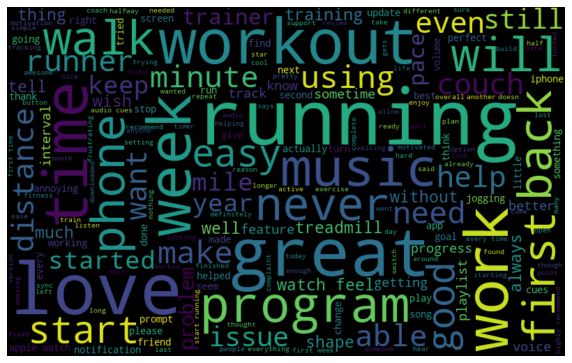

In [26]:
stopwords = set(STOPWORDS)
stopwords.update(['this', 'used', 'really', " ' ", "weight"])

words = " ".join(str(text) for text in dataset.clean_review)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=500, random_state=30, max_font_size=110).generate(words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
#Extracting words
def extract(x):
    words = []
    #Loop over the words in the content 
    for i in x: 
        word = re.findall(r"\b\w{4,225}\b",i)
        words.append(word)
        
    return words

In [28]:
#allWords = extract(dataset['clean_review'])
positive_w = extract(dataset['clean_review'][dataset['rating']>3])
negative_w = extract(dataset['clean_review'][dataset['rating']<3])
neutral_w = extract(dataset['clean_review'][dataset['rating']==3])
#allWords = sum(allWords, [])
#allWords

positive_w = sum(positive_w, [])
negative_w = sum(negative_w, [])
neutral_w = sum(neutral_w, [])

In [29]:
len(positive_w)

44493

In [30]:
#Dict of all Positive Words
pros_freq = nltk.FreqDist(positive_w)
dict_filter1 = lambda pros_freq, stopwords: dict((w, pros_freq[w]) for w in pros_freq if w not in stopwords)
positive = dict_filter1(pros_freq, stopwords)

In [31]:
#Dict of all Negative Words
neg_freq = nltk.FreqDist(negative_w)
dict_filter2 = lambda neg_freq, stopwords: dict((w, neg_freq[w]) for w in neg_freq if w not in stopwords)
negative = dict_filter2(neg_freq, stopwords)

In [32]:
#Dict of all Neutral Words 
neu_freq = nltk.FreqDist(neutral_w)
dict_filter3 = lambda neu_freq, stopwords: dict((w, neu_freq[w]) for w in neu_freq if w not in stopwords)
neutral = dict_filter3(neu_freq, stopwords)

In [33]:
#Dataframe of Positive Words with frequency count
sentiment_positive_freq = pd.DataFrame({'Positive_freq': list(positive.keys()),
                              'Positive_Count':list(positive.values()),
                             })

In [34]:
#Dataframe of Negative Words with frquency count 
sentiment_negative_freq = pd.DataFrame({ 'Negative_freq':list(negative.keys()), 
                              'Negative_Count':list(negative.values())
                             })

In [35]:
#Datafram of Neutral Words with frequency count 
sentiment_neutral_freq = pd.DataFrame({'Neutral_freq':list(neutral.keys()),
                                      'Neutral_Count':list(neutral.values())})

In [36]:
#Extracting real-relevant sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

pos_word_list = []
neg_word_list = []
neu_word_list = [] 
for word1 in sentiment_positive_freq['Positive_freq']:
    if(sid.polarity_scores(word1)['compound'])>0.5:
        pos_word_list.append(word1)

    

In [37]:
       
for word2 in sentiment_negative_freq['Negative_freq']:
    if(sid.polarity_scores(word2)['compound'])< -0.5:
        neg_word_list.append(word2)

In [38]:
neutral_pos = []
neutral_neg=[]
neutral_neu=[]
for word3 in sentiment_neutral_freq['Neutral_freq']:
    if(sid.polarity_scores(word3)['compound'])>=0.5:
        neutral_pos.append(word3)
    elif (sid.polarity_scores(word3)['compound'])<= -0.5:
        neutral_neg.append(word3)
    else:
        neutral_neu.append(word3)

In [40]:
neg_word_list

['horrible',
 'frustrated',
 'hate',
 'stupid',
 'crappy',
 'kills',
 'worst',
 'angry',
 'disappointment',
 'negative',
 'dead',
 'fail',
 'unprofessional',
 'disaster',
 'pain',
 'died',
 'terribly',
 'rejected',
 'dumb',
 'killing',
 'failing',
 'ugly',
 'scam',
 'sick',
 'cancer',
 'infuriating',
 'devastating',
 'cheated',
 'failure',
 'destroy',
 'kill']

In [74]:
neutral_neg

['hate',
 'ugly',
 'horrible',
 'hell',
 'dumb',
 'kills',
 'pain',
 'negative',
 'sick',
 'scams',
 'horribly',
 'disturbingly',
 'painfully',
 'stupid',
 'murders',
 'disturbing']

In [34]:
neutral_neu

['good',
 'easy',
 'simple',
 'nice',
 'gender',
 'accurate',
 'need',
 'better',
 'doesn',
 'height',
 'useful',
 'basic',
 'well',
 'time',
 'range',
 'year',
 'know',
 'says',
 'body',
 'pretty',
 'change',
 'obese',
 'overweight',
 'update',
 'option',
 'much',
 'info',
 'little',
 'cool',
 'calculator',
 'inches',
 'think',
 'please',
 'make',
 'gives',
 'adult',
 'information',
 'needs',
 'take',
 'date',
 'difference',
 'birth',
 'back',
 'works',
 'find',
 'feet',
 'shows',
 'skinny',
 'thin',
 'according',
 'using',
 'work',
 'check',
 'every',
 'nothing',
 'understand',
 'correct',
 'give',
 'born',
 'number',
 'dont',
 'application',
 'wish',
 'select',
 'lose',
 'okay',
 'enough',
 'thing',
 'thanks',
 'muscle',
 'even',
 'input',
 'screen',
 'though',
 'pounds',
 'keeps',
 'scale',
 'track',
 'size',
 'confusing',
 'factors',
 'apps',
 'general',
 'able',
 'tells',
 'proper',
 'class',
 'years',
 'sure',
 'alright',
 'something',
 'will',
 'point',
 'goes',
 'cant',
 'idea

In [189]:
from itertools import zip_longest
with open('A54_Sentiments.csv', "w") as f: 
    w = csv.writer(f)
    w.writerow(["Positive Sentiments", "Negative Sentiments"])
    for x, y in zip_longest(pos_word_list, neg_word_list):
        w.writerow([x,y])

,Positive Sentiments,Negative Sentiments
0,great,stupid
1,love,horrible
2,excellent,hate
3,ideal,worst
4,best,dumb
5,awesome,bullshit
6,perfect,dead
7,amazing,frustrated
8,super,unhealthy
9,loved,sick


In [190]:
s = pd.read_csv("A54_Sentiments.csv")
s

,Positive Sentiments,Negative Sentiments
0,love,horrible
1,great,frustrated
2,perfect,hate
3,best,stupid
4,amazing,crappy
...,...,...
70,excellently,NaN
71,hero,NaN
72,marvelous,NaN
73,perfection,NaN
